Epoch [1/500], Train Loss: 57.9105, Val Loss: 71.2554
Epoch [2/500], Train Loss: 54.2315, Val Loss: 60.5019
Epoch [3/500], Train Loss: 43.4596, Val Loss: 54.1311
Epoch [4/500], Train Loss: 40.4228, Val Loss: 51.9070
Epoch [5/500], Train Loss: 40.6679, Val Loss: 50.5730
Epoch [6/500], Train Loss: 50.9897, Val Loss: 49.3686
Epoch [7/500], Train Loss: 37.7466, Val Loss: 48.4843
Epoch [8/500], Train Loss: 37.0568, Val Loss: 47.8704
Epoch [9/500], Train Loss: 35.1907, Val Loss: 47.6495
Epoch [10/500], Train Loss: 34.1400, Val Loss: 43.1778
Epoch [11/500], Train Loss: 31.7280, Val Loss: 41.2903
Epoch [12/500], Train Loss: 30.5126, Val Loss: 40.0566
Epoch [13/500], Train Loss: 29.3231, Val Loss: 38.3245
Epoch [14/500], Train Loss: 28.3594, Val Loss: 36.8443
Epoch [15/500], Train Loss: 27.2086, Val Loss: 35.8279
Epoch [16/500], Train Loss: 26.3985, Val Loss: 34.6766
Epoch [17/500], Train Loss: 25.7606, Val Loss: 33.7285
Epoch [18/500], Train Loss: 28.5056, Val Loss: 32.7026
Epoch [19/500], Tra

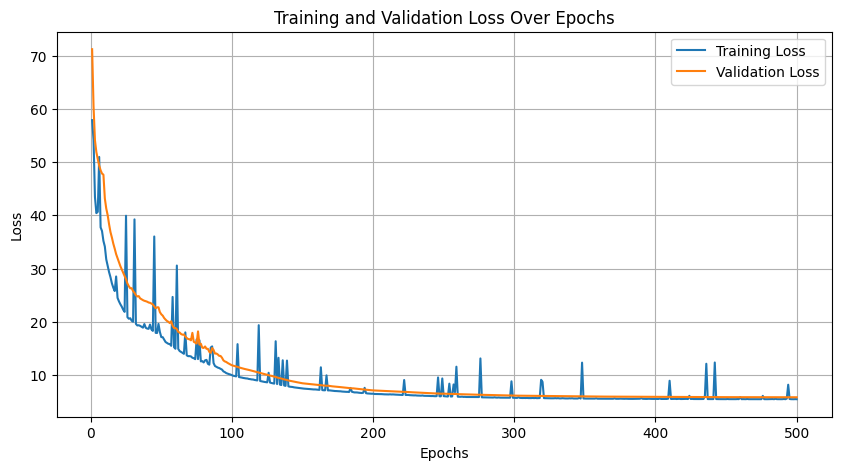

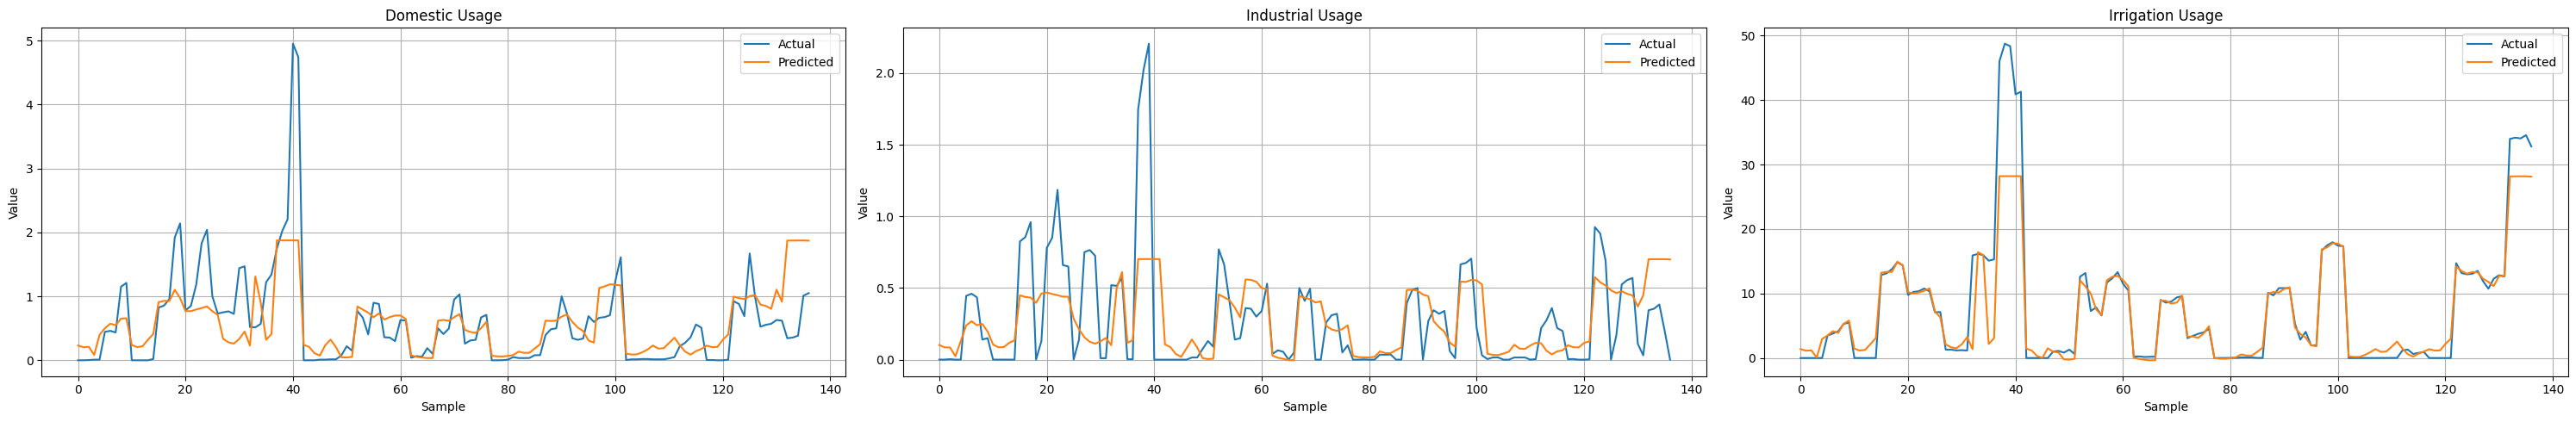

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from src.data import WaterDataset
from src.model import LSTM
import numpy as np
import matplotlib.pyplot as plt

dataset = WaterDataset()
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset, batch_size=8, shuffle=False)

input_dim = train_dataset[0][0].shape[1]  # Number of features in input
output_dim = 3  # 3 outputs (Domestic, Industrial, Irrigation)
hidden_dim = 128
num_layers = 4
dropout = 0.3

# Model, loss function, and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTM(input_size=input_dim, lstm_layer_sizes=[32,64,32], output_size=output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training loop
num_epochs = 500
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    # Step the scheduler
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Testing phase for actual vs. predicted plot
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(labels.cpu().numpy())

# Convert lists to arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Plot actual vs predicted values for each output
plt.figure(figsize=(30, 5))
for i, label in enumerate(['Domestic', 'Industrial', 'Irrigation']):
    plt.subplot(1, 3, i+1)
    plt.plot(actuals[:, i], label='Actual')
    plt.plot(predictions[:, i], label='Predicted')
    plt.title(f'{label} Usage')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
